# 1. Differential junction usage analysis

In [1]:
library(dplyr)
library(ggplot2)
library(DESeq2)
library(car)
library(plotly)
library(reshape2)
library(biomaRt)
library(future.apply)
library(clusterProfiler)
library(org.Hs.eg.db)
library(msigdbr)
library(enrichplot)
source(file='leafcutterAS_wrapperscript.R')

load(file='/data/data/proteogenomics/vincent/20211015_human_ESCNPCNeu_isoHD/leafcutterAStable_human_ESCNPCNeu_isoHD_clean.RData')



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘ggplot2’ was built under R version 4.0.5”
Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
  

# 1.1. Principal component analysis (PCA) of intron usage

In [2]:
IsoHD_DSJs_numers <- read.table(file='data/1.IsoHD_DSJs_numers.tsv.gz',header=TRUE,sep='\t')
IsoHD_DSJs_ratio <- read.table(file='data/1.IsoHD_DSJs_ratio.tsv.gz',header=TRUE,sep='\t',row.names=1)
IsoHD_DSJs_rowdata <- read.table(file='data/1.IsoHD_DSJs_rowdata.tsv.gz',header=TRUE,sep='\t')


In [3]:
# convert ratio character string to numeric
IsoHD_DSJs_ratio <- IsoHD_DSJs_ratio %>% 
apply(2,function(x) ((gsub('/.*','',x) %>% as.numeric)/(gsub('.*/','',x) %>% as.numeric))) %>% 
data.frame(row.names=IsoHD_DSJs_ratio %>% row.names)


In [4]:
IsoHD_DSJs_rowdata <- IsoHD_DSJs_rowdata %>% 
data.frame(
    row.names=IsoHD_DSJs_rowdata %>% with(paste0(Chr,':',Start,':',End,':',Cluster))
)


In [5]:
coldata <- IsoHD_DSJs_numers %>% colnames %>% 
strsplit(split='_') %>% 
lapply(function(x) data.frame(Celltype=x[1],Genotype=x[2],Replicate=x[3])) %>% 
(function(dflist) do.call(rbind,dflist)) %>% 
data.frame(row.names=IsoHD_DSJs_numers %>% colnames)

coldata$Celltype <- coldata$Celltype %>% factor(levels=c('ESC','NPC','Neu'),labels=c('ESC','NPC','NEU'))
coldata$Genotype <- coldata$Genotype %>% factor(levels=c('H9','Q30','45Q','Q45','81Q','Q81'),labels=c('Control','Control','45Q','45Q','81Q','81Q'))
coldata$Genotype <- coldata$Replicate %>% factor
 

In [6]:
# junctions annotated in Ensembl gtf with at least 100 spanning reads
knownjunctions <- IsoHD_DSJs_rowdata %>% 
subset(known_junction=='1'&Score>=100) %>% 
with(paste0(Chr,':',Start,':',End,':',Cluster))


## 1.1.1. PCA by junction counts

In [7]:
# use DESeq2 for variance stabilising transform
ddsnumers <- DESeqDataSetFromMatrix(
    countData = IsoHD_DSJs_numers, 
    colData = coldata, 
    design = ~Replicate + Celltype
)


Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


In [8]:
ddsnumers <- ddsnumers %>% estimateSizeFactors %>% estimateDispersions


gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



In [9]:
vsdnumers <- ddsnumers %>% vst(blind=TRUE)


In [10]:
# PCA with top 1000 variance junctions
prcomp.vsdnumers <- vsdnumers %>% assay %>% 
(function(vstcounts) {
    highlyvargenesorder <- vstcounts %>% apply(1,var) %>% order(decreasing=TRUE)
    vstcounts[highlyvargenesorder[1:1000],] %>% t %>% prcomp(scale.=TRUE) %>% summary
})


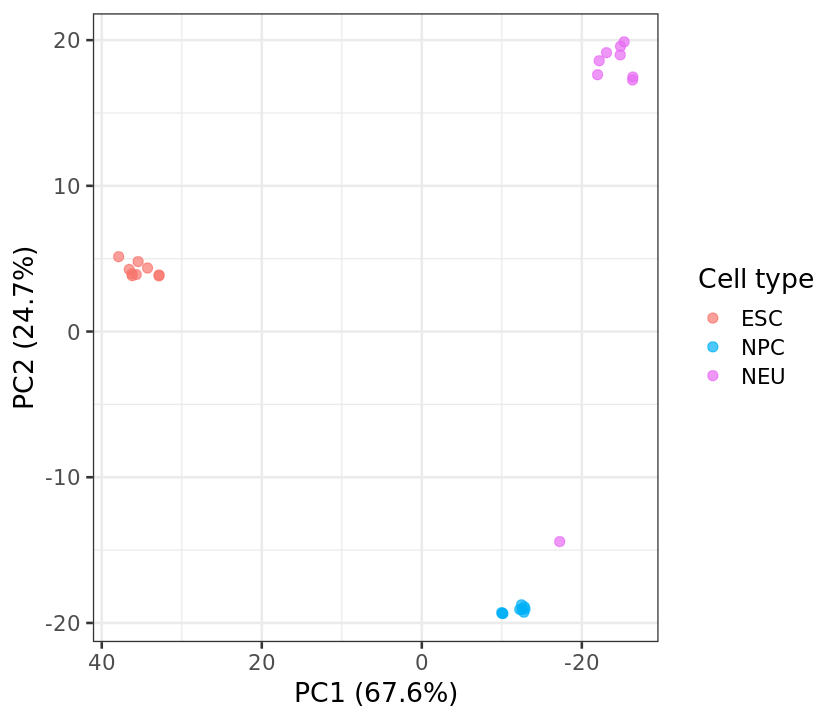

In [11]:
options(repr.plot.width=7,repr.plot.height=6)
g <- prcomp.vsdnumers$x %>% data.frame %>% 
ggplot(
    mapping=aes(
        x=PC1,y=PC2,
        color=vsdnumers@colData$Celltype,
        text=vsdnumers@colData %>% row.names
    )
) +
geom_point(size=2.5,alpha=.7) +
scale_color_manual(name='Cell type',values=c('ESC'=hcl(h=seq(15,375,length=5+1),l=65,c=100)[1],
                                             'NPC'=hcl(h=seq(15,375,length=5+1),l=65,c=100)[4],
                                             'NEU'=hcl(h=seq(15,375,length=5+1),l=65,c=100)[5])) +
labs(
    x=paste0('PC1 (',sprintf('%.1f',100*prcomp.vsdnumers$importance[2,'PC1']),'%)'),
    y=paste0('PC2 (',sprintf('%.1f',100*prcomp.vsdnumers$importance[2,'PC2']),'%)')
) +
theme_bw(base_size=16) +
scale_x_reverse()

#g %>% ggplotly(width=700,height=600,tooltip='all')
g


## 1.1.2. PCA by junction usage ratio

In [12]:
# logit transform
IsoHD_DSJs_logit <- IsoHD_DSJs_ratio %>% 
logit


Warning message in logit(.):
“proportions remapped to (0.025, 0.975)”


In [13]:
# PCA with top 1000 variance junctions
prcomp.logit <- IsoHD_DSJs_logit %>% 
(function(logitscores) {
    highlyvargenesorder <- logitscores %>% apply(1,var) %>% order(decreasing=TRUE)
    logitscores[highlyvargenesorder[1:1000],] %>% t %>% prcomp(scale.=TRUE) %>% summary
})


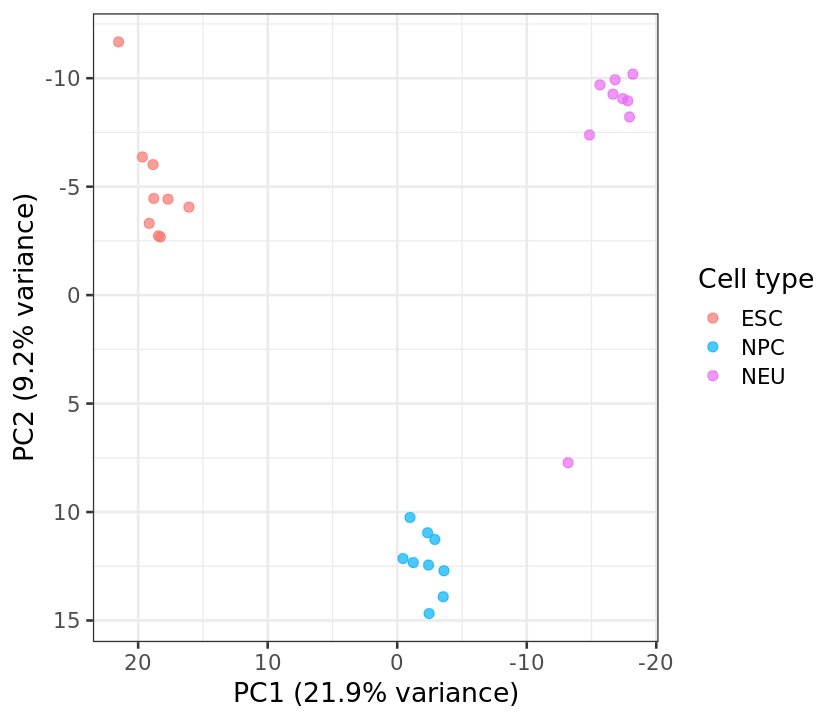

In [14]:
options(repr.plot.width=7,repr.plot.height=6)
g <- prcomp.logit$x %>% data.frame %>% 
ggplot(
    mapping=aes(
        x=PC1,y=PC2,
        color=coldata$Celltype,
        text=coldata %>% row.names
    )
) +
geom_point(size=2.5,alpha=.7) +
scale_color_manual(name='Cell type',values=c('ESC'=hcl(h=seq(15,375,length=5+1),l=65,c=100)[1],
                                             'NPC'=hcl(h=seq(15,375,length=5+1),l=65,c=100)[4],
                                             'NEU'=hcl(h=seq(15,375,length=5+1),l=65,c=100)[5])) +
labs(
    x=paste0('PC1 (',sprintf('%.1f',100*prcomp.logit$importance[2,'PC1']),'% variance)'),
    y=paste0('PC2 (',sprintf('%.1f',100*prcomp.logit$importance[2,'PC2']),'% variance)')
) +
theme_bw(base_size=16) +
scale_x_reverse() + scale_y_reverse()

#g %>% ggplotly(width=700,height=600,tooltip='all')
g


# 1.2. Annotation of leafcutter splice junction clusters

In [15]:
# load all leafcutter_ds_effect_sizes files appended with cluster P-values (data not included)
intronsjunctions.list <- list.files(path = '.', pattern = '.*.leafcutter_ds_effect_sizes.highlyused.annotated.csv') %>% 
future_lapply(function(filename) {
    read.table(
        file = file.path('.',filename),
        header = TRUE,
        sep = "\t",
        row.names = NULL
    )
}) %>% setNames(nm = gsub('\\.','_',gsub('.leafcutter_ds_effect_sizes.highlyused.annotated.csv','',list.files(path = '.', pattern = '.*.leafcutter_ds_effect_sizes.highlyused.annotated.csv'))))


In [16]:
# recluster overlapping junctions
clusters.list <- intronsjunctions.list %>% 
lapply(with, Cluster)

intronjunctionslist.list <- intronsjunctions.list %>% names %>% 
future_lapply(function(samplename) {
    split(x = intronsjunctions.list[[samplename]], f = clusters.list[[samplename]])
}) %>% setNames(nm = intronsjunctions.list %>% names)

intronjunctionsintersectlist.list <- intronjunctionslist.list %>% names %>% 
future_lapply(function(samplename) {
    lapply(intronjunctionslist.list[[samplename]], function(x) intersectgenomiccoordinates(rankgenomiccoordinates(x)))
}) %>% setNames(nm = intronjunctionslist.list %>% names)

intronjunctionsintersectlistlong.list <- intronjunctionsintersectlist.list %>% 
future_lapply(function(x) do.call('c',x))

intronjunctionsintersectlistlongrenamed.list <- intronjunctionsintersectlistlong.list %>% 
future_lapply(function(intronjunctionsintersectlistlong) {
    intronjunctionsintersectlistlong %>% 
    lapply(function(x) {
        y <- unlist(x[,2:3])
        rename <- setNames(object = seq_len(length(unique(sort(y)))),
                           nm = unique(sort(y)))
        x[,2:3] <- matrix(data = rename[as.character(y)], nrow = nrow(x))
        x
    })
})

intronjunctionsintersectlistlongrenameddf.list <- intronjunctionsintersectlistlongrenamed.list %>% 
lapply(function(mydataset) {
    mydataset %>% #head(n=5) %>% 
    names %>% 
    future_lapply(function(newclustername) {
        mydataset[[newclustername]] %>% data.frame(renamedCluster=newclustername)
    }) %>% 
    (function(dflist) do.call(rbind,dflist))
})


In [17]:
# annotate putative AS event type using custom R script
intronjunctionsAS_table.list <- intronjunctionsintersectlistlongrenameddf.list %>% names %>% 
future_lapply(function(samplename) {
    intronjunctionsintersectlistlongrenameddf.list[[samplename]] %>% annotatePutativeASEventTypeTable
}) %>% setNames(nm=intronjunctionsintersectlistlongrenameddf.list %>% names)


In [18]:
# filter for clusters containing at least one significant junction (ΔPSI≥1% & adjusted P-val≤0.1)
significantjunctions.list <- intronsjunctions.list %>% 
future_lapply(function(x) {
    x %>% 
    subset(abs(deltapsi)>=.01&padj<=.1) %>% 
    with(Junction %>% unique)
})
significantclusters.list <- intronsjunctions.list %>% names %>% 
future_lapply(function(samplename) {
    intronsjunctions.list[[samplename]] %>% 
    subset(Junction %in% significantjunctions.list[[samplename]]) %>% 
    with(Cluster %>% unique)
}) %>% setNames(nm = intronsjunctions.list %>% names)
significantintronjunctionsAS_table.list <- intronjunctionsAS_table.list %>% names %>% 
future_lapply(function(samplename) {
    intronjunctionsAS_table.list[[samplename]][(intronjunctionsAS_table.list[[samplename]] %>% row.names %>% strsplit(split = "\\.") %>% lapply(function(x) x[1]) %>% unlist) %in% significantclusters.list[[samplename]],]
}) %>% setNames(nm = intronjunctionsAS_table.list %>% names)

# filter for clusters containing at least one robust junction (ΔPSI≥5% & adjusted P-val≤0.1)
robustjunctions.list <- intronsjunctions.list %>% 
future_lapply(function(x) {
    x %>% 
    subset(abs(deltapsi)>=.05&padj<=.1) %>% 
    with(Junction %>% unique)
})
robustclusters.list <- intronsjunctions.list %>% names %>% 
future_lapply(function(samplename) {
    intronsjunctions.list[[samplename]] %>% 
    subset(Junction %in% robustjunctions.list[[samplename]]) %>% 
    with(Cluster %>% unique)
}) %>% setNames(nm = intronsjunctions.list %>% names)
robustintronjunctionsAS_table.list <- intronjunctionsAS_table.list %>% names %>% 
future_lapply(function(samplename) {
    intronjunctionsAS_table.list[[samplename]][(intronjunctionsAS_table.list[[samplename]] %>% row.names %>% strsplit(split = "\\.") %>% lapply(function(x) x[1]) %>% unlist) %in% robustclusters.list[[samplename]],]
}) %>% setNames(nm = intronjunctionsAS_table.list %>% names)
                              

In [19]:
significantintronjunctionsintersectlistlongrenameddf.list <- intronjunctionsintersectlistlongrenameddf.list %>% 
future_lapply(function(mydf) {
    includerenamedcluster <- mydf$deltapsi %>% 
    split(f=mydf$renamedCluster) %>% 
    lapply(function(x) ((x %>% abs)>=.01) %>% any) %>% 
    unlist
           
    includerenamedcluster <- includerenamedcluster[includerenamedcluster] %>% names
    mydf %>% subset((padj<=.05) & (renamedCluster %in% includerenamedcluster))
})

robustintronjunctionsintersectlistlongrenameddf.list <- intronjunctionsintersectlistlongrenameddf.list %>% 
future_lapply(function(mydf) {
    includerenamedcluster <- mydf$deltapsi %>% 
    split(f=mydf$renamedCluster) %>% 
    lapply(function(x) ((x %>% abs)>=.05) %>% any) %>% 
    unlist
           
    includerenamedcluster <- includerenamedcluster[includerenamedcluster] %>% names
    mydf %>% subset((padj<=.05) & (renamedCluster %in% includerenamedcluster))
})


In [20]:
significantintronjunctionsintersectlistlongrenameddf.list <- significantintronjunctionsintersectlistlongrenameddf.list %>% names %>% 
future_lapply(function(samplename) {
    AStable <- significantintronjunctionsAS_table.list[[samplename]] %>% 
    annotatePutativeASEventType
    
    significantintronjunctionsintersectlistlongrenameddf.list[[samplename]] %>% 
    mutate(
        ClusterASType=AStable[significantintronjunctionsintersectlistlongrenameddf.list[[samplename]]$renamedCluster,'ASType']
    ) %>% 
    mutate(
        clusterContainsNovelJunction=(known_junction %>% split(f=renamedCluster) %>% lapply(function(x) (x==0) %>% any) %>% unlist)[[renamedCluster]]
    )
}) %>% setNames(nm=significantintronjunctionsintersectlistlongrenameddf.list %>% names)

robustintronjunctionsintersectlistlongrenameddf.list <- robustintronjunctionsintersectlistlongrenameddf.list %>% names %>% 
future_lapply(function(samplename) {
    AStable <- robustintronjunctionsAS_table.list[[samplename]] %>% 
    annotatePutativeASEventType
    
    robustintronjunctionsintersectlistlongrenameddf.list[[samplename]] %>% 
    mutate(
        ClusterASType=AStable[robustintronjunctionsintersectlistlongrenameddf.list[[samplename]]$renamedCluster,'ASType']
    ) %>% 
    mutate(
        clusterContainsNovelJunction=(known_junction %>% split(f=renamedCluster) %>% lapply(function(x) (x==0) %>% any) %>% unlist)[[renamedCluster]]
    )
}) %>% setNames(nm=robustintronjunctionsintersectlistlongrenameddf.list %>% names)


In [21]:
EVENT_INFO.hg38.tab <- read.table(file='EVENT_INFO-hg38.tab',header=TRUE,sep='\t')
EVENT_INFO.mm10.tab <- read.table(file='EVENT_INFO-mm10.tab',header=TRUE,sep='\t')
EVENT_CONSERVATION.tab <- read.table(file='EVENT_CONSERVATION.tab',header=TRUE,sep='\t')
EVENT_CONSERVATION.tab.hg38mm10 <- EVENT_CONSERVATION.tab %>% 
subset((Ass1 %in% c('hg38','mm10'))&(Ass2 %in% c('hg38','mm10')))


In [22]:
significantintronjunctionsintersectlistlongrenameddf.knowncassetteexon.list2 <- significantintronjunctionsintersectlistlongrenameddf.list %>% 
future_lapply(function(renameddf) {
    renameddf %>% 
    .match_cassetteexon(
        EVENT_INFO=EVENT_INFO.hg38.tab,
        EVENT_CONSERVATION=EVENT_CONSERVATION.tab.hg38mm10,
        deltapsicutoff=.01,
        padjcutoff=.1,
        containnoveljunction=FALSE
    )
})

significantintronjunctionsintersectlistlongrenameddf.knowna5ss.list2 <- significantintronjunctionsintersectlistlongrenameddf.list %>% 
future_lapply(function(renameddf) {
    renameddf %>% 
    .match_alt5ss(
        EVENT_INFO=EVENT_INFO.hg38.tab,
        EVENT_CONSERVATION=EVENT_CONSERVATION.tab.hg38mm10,
        deltapsicutoff=.01,
        padjcutoff=.1,
        containnoveljunction=FALSE
    )
})

significantintronjunctionsintersectlistlongrenameddf.knowna3ss.list2 <- significantintronjunctionsintersectlistlongrenameddf.list %>% 
future_lapply(function(renameddf) {
    renameddf %>% 
    .match_alt3ss(
        EVENT_INFO=EVENT_INFO.hg38.tab,
        EVENT_CONSERVATION=EVENT_CONSERVATION.tab.hg38mm10,
        deltapsicutoff=.01,
        padjcutoff=.1,
        containnoveljunction=FALSE
    )
})

significantintronjunctionsintersectlistlongrenameddf.knownretainedintron.list2 <- significantintronjunctionsintersectlistlongrenameddf.list %>% 
future_lapply(function(renameddf) {
    renameddf %>% 
    .match_retainedintron(
        EVENT_INFO=EVENT_INFO.hg38.tab,
        EVENT_CONSERVATION=EVENT_CONSERVATION.tab.hg38mm10,
        deltapsicutoff=.01,
        padjcutoff=.1,
        containnoveljunction=FALSE
    )
})

significantintronjunctionsintersectlistlongrenameddf.novelcassetteexon.list2 <- significantintronjunctionsintersectlistlongrenameddf.list %>% 
future_lapply(function(renameddf) {
    renameddf %>% 
    .match_cassetteexon(
        EVENT_INFO=EVENT_INFO.hg38.tab,
        EVENT_CONSERVATION=EVENT_CONSERVATION.tab.hg38mm10,
        deltapsicutoff=.01,
        padjcutoff=.1,
        containnoveljunction=TRUE
    )
})

significantintronjunctionsintersectlistlongrenameddf.novela5ss.list2 <- significantintronjunctionsintersectlistlongrenameddf.list %>% 
future_lapply(function(renameddf) {
    renameddf %>% 
    .match_alt5ss(
        EVENT_INFO=EVENT_INFO.hg38.tab,
        EVENT_CONSERVATION=EVENT_CONSERVATION.tab.hg38mm10,
        deltapsicutoff=.01,
        padjcutoff=.1,
        containnoveljunction=TRUE
    )
})

significantintronjunctionsintersectlistlongrenameddf.novela3ss.list2 <- significantintronjunctionsintersectlistlongrenameddf.list %>% 
future_lapply(function(renameddf) {
    renameddf %>% 
    .match_alt3ss(
        EVENT_INFO=EVENT_INFO.hg38.tab,
        EVENT_CONSERVATION=EVENT_CONSERVATION.tab.hg38mm10,
        deltapsicutoff=.01,
        padjcutoff=.1,
        containnoveljunction=TRUE
    )
})

significantintronjunctionsintersectlistlongrenameddf.novelretainedintron.list2 <- significantintronjunctionsintersectlistlongrenameddf.list %>% 
future_lapply(function(renameddf) {
    renameddf %>% 
    .match_retainedintron(
        EVENT_INFO=EVENT_INFO.hg38.tab,
        EVENT_CONSERVATION=EVENT_CONSERVATION.tab.hg38mm10,
        deltapsicutoff=.01,
        padjcutoff=.1,
        containnoveljunction=TRUE
    )
})


In [23]:
robustintronjunctionsintersectlistlongrenameddf.knowncassetteexon.list2 <- robustintronjunctionsintersectlistlongrenameddf.list %>% 
future_lapply(function(renameddf) {
    renameddf %>% 
    .match_cassetteexon(
        EVENT_INFO=EVENT_INFO.hg38.tab,
        EVENT_CONSERVATION=EVENT_CONSERVATION.tab.hg38mm10,
        deltapsicutoff=.05,
        padjcutoff=.1,
        containnoveljunction=FALSE
    )
})

robustintronjunctionsintersectlistlongrenameddf.knowna5ss.list2 <- robustintronjunctionsintersectlistlongrenameddf.list %>% 
future_lapply(function(renameddf) {
    renameddf %>% 
    .match_alt5ss(
        EVENT_INFO=EVENT_INFO.hg38.tab,
        EVENT_CONSERVATION=EVENT_CONSERVATION.tab.hg38mm10,
        deltapsicutoff=.05,
        padjcutoff=.1,
        containnoveljunction=FALSE
    )
})

robustintronjunctionsintersectlistlongrenameddf.knowna3ss.list2 <- robustintronjunctionsintersectlistlongrenameddf.list %>% 
future_lapply(function(renameddf) {
    renameddf %>% 
    .match_alt3ss(
        EVENT_INFO=EVENT_INFO.hg38.tab,
        EVENT_CONSERVATION=EVENT_CONSERVATION.tab.hg38mm10,
        deltapsicutoff=.05,
        padjcutoff=.1,
        containnoveljunction=FALSE
    )
})

robustintronjunctionsintersectlistlongrenameddf.knownretainedintron.list2 <- robustintronjunctionsintersectlistlongrenameddf.list %>% 
future_lapply(function(renameddf) {
    renameddf %>% 
    .match_retainedintron(
        EVENT_INFO=EVENT_INFO.hg38.tab,
        EVENT_CONSERVATION=EVENT_CONSERVATION.tab.hg38mm10,
        deltapsicutoff=.05,
        padjcutoff=.1,
        containnoveljunction=FALSE
    )
})

robustintronjunctionsintersectlistlongrenameddf.novelcassetteexon.list2 <- robustintronjunctionsintersectlistlongrenameddf.list %>% 
future_lapply(function(renameddf) {
    renameddf %>% 
    .match_cassetteexon(
        EVENT_INFO=EVENT_INFO.hg38.tab,
        EVENT_CONSERVATION=EVENT_CONSERVATION.tab.hg38mm10,
        deltapsicutoff=.05,
        padjcutoff=.1,
        containnoveljunction=TRUE
    )
})

robustintronjunctionsintersectlistlongrenameddf.novela5ss.list2 <- robustintronjunctionsintersectlistlongrenameddf.list %>% 
future_lapply(function(renameddf) {
    renameddf %>% 
    .match_alt5ss(
        EVENT_INFO=EVENT_INFO.hg38.tab,
        EVENT_CONSERVATION=EVENT_CONSERVATION.tab.hg38mm10,
        deltapsicutoff=.05,
        padjcutoff=.1,
        containnoveljunction=TRUE
    )
})

robustintronjunctionsintersectlistlongrenameddf.novela3ss.list2 <- robustintronjunctionsintersectlistlongrenameddf.list %>% 
future_lapply(function(renameddf) {
    renameddf %>% 
    .match_alt3ss(
        EVENT_INFO=EVENT_INFO.hg38.tab,
        EVENT_CONSERVATION=EVENT_CONSERVATION.tab.hg38mm10,
        deltapsicutoff=.05,
        padjcutoff=.1,
        containnoveljunction=TRUE
    )
})

robustintronjunctionsintersectlistlongrenameddf.novelretainedintron.list2 <- robustintronjunctionsintersectlistlongrenameddf.list %>% 
future_lapply(function(renameddf) {
    renameddf %>% 
    .match_retainedintron(
        EVENT_INFO=EVENT_INFO.hg38.tab,
        EVENT_CONSERVATION=EVENT_CONSERVATION.tab.hg38mm10,
        deltapsicutoff=.05,
        padjcutoff=.1,
        containnoveljunction=TRUE
    )
})


In [24]:
significantintronjunctionsintersectlistlongrenameddf.vastdbevents.list2 <- significantintronjunctionsintersectlistlongrenameddf.knowncassetteexon.list2 %>% names %>% 
lapply(function(samplename) {
    rbind(
        significantintronjunctionsintersectlistlongrenameddf.knowncassetteexon.list2[[samplename]][,1:33],
        significantintronjunctionsintersectlistlongrenameddf.knowna5ss.list2[[samplename]][,1:33],
        significantintronjunctionsintersectlistlongrenameddf.knowna3ss.list2[[samplename]][,1:33],
        significantintronjunctionsintersectlistlongrenameddf.knownretainedintron.list2[[samplename]][,1:33]
    )
}) %>% setNames(nm=significantintronjunctionsintersectlistlongrenameddf.knowncassetteexon.list2 %>% names)

significantintronjunctionsintersectlistlongrenameddf.conservedevents.list2 <- significantintronjunctionsintersectlistlongrenameddf.vastdbevents.list2 %>% 
lapply(subset,ConservedID!='\\N')


In [25]:
significantintronjunctionsintersectlistlongrenameddf.vastdbevents.df2 <- significantintronjunctionsintersectlistlongrenameddf.vastdbevents.list2 %>% names %>% 
lapply(function(samplename) {
    data.frame(
        DiffSplicing.test=samplename,
        significantintronjunctionsintersectlistlongrenameddf.vastdbevents.list2[[samplename]]
    )
}) %>% 
(function(dflist) do.call(rbind,dflist))


In [26]:
options(repr.plot.height=7,repr.plot.width=7)
significantintronjunctionsintersectlistlongrenameddf.vastdbevents.df2 %>% 
subset(!grepl('^Cell_type_|^disease_stage_',DiffSplicing.test)) %>% 
(function(mydf) {
    ds.test <- gsub('_disease_stage_.*','',mydf$DiffSplicing.test)
    ds.test <- gsub('^ESC$','hESC',ds.test)
    dflist <- mydf %>% 
    split(f=ds.test)
    
    eventlist <- dflist %>% 
    lapply(with,gsub('-[0-9]/[0-9]$','',EVENT) %>% na.omit %>% unique %>% sort)
    
    uniqueeventlist <- eventlist %>% names %>% 
    lapply(function(celltype) {
        eventlist[[celltype]][(!(eventlist[[celltype]] %in% (eventlist[!grepl(celltype,eventlist %>% names)] %>% unlist)))]
    }) %>% setNames(nm=eventlist %>% names)
    
    eventlist %>% names %>% 
    lapply(function(celltype) {
        dflist[[celltype]] %>% 
        subset(gsub('-[0-9]/[0-9]$','',EVENT) %in% eventlist[[celltype]]) %>% 
        subset((deltapsi %>% abs)>=.05) %>% 
        with(JunctionName) %>% sort %>% unique %>% length
    }) %>% setNames(nm=eventlist %>% names)
})


$hESC
[1] 2046

$Neuron
[1] 692

$NPC
[1] 299

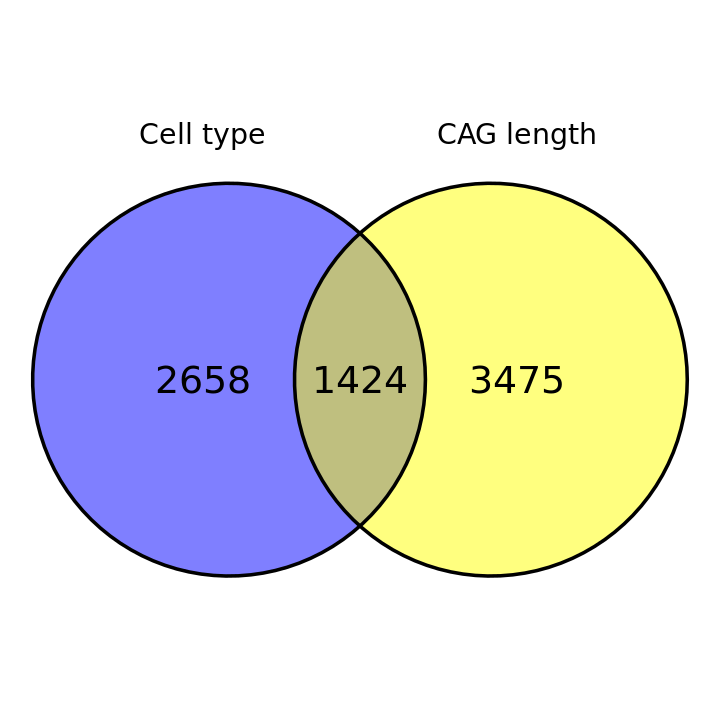

In [27]:
# overlap of Cell type- and CAG length-dependent differential splicing events
options(repr.plot.height=6,repr.plot.width=6)
significantintronjunctionsintersectlistlongrenameddf.vastdbevents.df2 %>% 
subset(!grepl('^disease_stage_',DiffSplicing.test)) %>% 
(function(mydf) {
    ds.test <- gsub('.*disease_stage_.*','CAG length',mydf$DiffSplicing.test)
    ds.test <- gsub('^Cell_type_NPCvsESC','Cell type',ds.test)
    #return(ds.test %>% table)
    
    dflist <- mydf %>% 
    split(f=ds.test %>% factor(levels=c('Cell type','CAG length')))
    eventlist <- dflist %>% 
    lapply(with,gsub('-[0-9]/[0-9]$','',EVENT) %>% na.omit %>% unique)
    
    ggvenn::ggvenn(
        data=eventlist,
        #fill_color=c(
        #    hcl(h=seq(15,375,length=5+1),l=65,c=100)[1],
        #    hcl(h=seq(15,375,length=5+1),l=65,c=100)[4],
        #    hcl(h=seq(15,375,length=5+1),l=65,c=100)[5],
        #    hcl(h=seq(15,375,length=5+1),l=65,c=100)[3]
        #),
        show_percentage=FALSE,
        text_size=8
    )
})


## 1.2.2. Functional enrichment of Gene Ontology terms

In [28]:
hg38samtags <- read.table(file='Homo_sapiens.GRCh38.96.samtags.tsv',header=TRUE,sep='\t')

gobp_gene_sets <- msigdbr(species = "Homo sapiens", category = "C5", subcategory = "GO:BP")
gobp_t2g <- gobp_gene_sets %>% dplyr::distinct(gs_name,entrez_gene=entrez_gene %>% as.character) %>% as.data.frame()


In [29]:
geneidsuniverse <- hg38samtags %>% 
subset(gene_name %in% (
    intronjunctionsintersectlistlongrenameddf.list %>% 
    lapply(with,genes) %>% unlist %>% 
    unique %>% strsplit(split=',') %>% 
    unlist %>% unique
)) %>% 
with(gene_id) %>% 
unique

hs_mart <- useEnsembl(biomart='genes',dataset="hsapiens_gene_ensembl",mirror='asia')
genesuniverseBM <- getBM(
    filters = "ensembl_gene_id", 
    attributes = c('ensembl_gene_id','entrezgene_id','hgnc_symbol','description'),
    values = geneidsuniverse,
    mart = hs_mart,
    useCache = FALSE
)
genesuniverseBM$entrezgene_id <- genesuniverseBM$entrezgene_id %>% as.character
entrezgeneidsuniverse <- genesuniverseBM %>% subset(ensembl_gene_id %in% geneidsuniverse) %>% with(entrezgene_id %>% as.character %>% unique)


In [30]:
significantintronjunctionsintersectlistlongrenameddf.summarised.enrichGOBP.list <- list(
    Cell_type_NPCvsESC=grep('Cell_type_NPCvsESC',significantintronjunctionsintersectlistlongrenameddf.list %>% names),
    disease_stage_ESC=grep('ESC_disease_stage_(45Q|81Q)vsH9',significantintronjunctionsintersectlistlongrenameddf.list %>% names),
    disease_stage_NPC=grep('NPC_disease_stage_(45Q|81Q)vsH9',significantintronjunctionsintersectlistlongrenameddf.list %>% names),    
    disease_stage_Neuron=grep('Neuron_disease_stage_(45Q|81Q)vs30Q',significantintronjunctionsintersectlistlongrenameddf.list %>% names)
) %>% 
lapply(function(x) {
    mydf <- do.call(rbind,significantintronjunctionsintersectlistlongrenameddf.list[x])
    genesymbols <- mydf %>% 
    subset(ClusterASType!='Unknown' & ClusterASType!='Mixed') %>% 
    with(genes) %>% 
    strsplit(split=',') %>% 
    unlist %>% 
    unique
    if ((genesymbols %>% is.null)|((genesymbols %>% length)<=1)) {
        message('genesymbols <= 1. return NULL')
        return(NULL)
    }

    ensemblgeneids <- hg38samtags %>% subset(gene_name %in% genesymbols) %>% with(gene_id) %>% unique
    
    outenrichdf <- ensemblgeneids %>% 
    enrichGO(
        OrgDb=org.Hs.eg.db,
        keyType='ENSEMBL',
        ont='BP',
        universe=geneidsuniverse,
        pvalueCutoff=.1,
        qvalueCutoff=.1
    )
    message(paste0('Analysed ',ensemblgeneids %>% length,' genes. ',outenrichdf %>% nrow,' terms enriched.'))
    return(outenrichdf)    
}) %>% setNames(nm=c('Cell_type_NPCvsESC','disease_stage_ESC','disease_stage_NPC','disease_stage_Neuron'))

significantintronjunctionsintersectlistlongrenameddf.summarised.enrichGOBP.df <- significantintronjunctionsintersectlistlongrenameddf.summarised.enrichGOBP.list %>% names %>% 
lapply(function(datasetname) {
    if (((significantintronjunctionsintersectlistlongrenameddf.summarised.enrichGOBP.list[[datasetname]] %>% nrow)==0)|(significantintronjunctionsintersectlistlongrenameddf.summarised.enrichGOBP.list[[datasetname]] %>% is.null)) return(NULL)
    data.frame(
        Dataset=datasetname,
        significantintronjunctionsintersectlistlongrenameddf.summarised.enrichGOBP.list[[datasetname]] %>% data.frame,
        row.names=NULL
    )
}) %>% 
(function(dflist) do.call(rbind,dflist))
 

In [31]:
significantintronjunctionsintersectlistlongrenameddf.summarised.enrichGOBP.list2 <- significantintronjunctionsintersectlistlongrenameddf.summarised.enrichGOBP.list %>% 
future_lapply(pairwise_termsim)


In [32]:
includeterms <- c()
excludeterms <- c()

for (i in (significantintronjunctionsintersectlistlongrenameddf.summarised.enrichGOBP.list2 %>% seq_along)) {
    for (term in (significantintronjunctionsintersectlistlongrenameddf.summarised.enrichGOBP.list2[[i]]@termsim %>% row.names)) {
        if ((term %in% excludeterms)) { #|(term %in% includeterms)
            next
        } else {
            similarterms <- c(
                term,
                significantintronjunctionsintersectlistlongrenameddf.summarised.enrichGOBP.list2[[i]]@termsim[
                    term,
                    significantintronjunctionsintersectlistlongrenameddf.summarised.enrichGOBP.list2[[i]]@termsim[term,]>=.4
                ] %>% na.omit %>% names
            )

            outterms <- significantintronjunctionsintersectlistlongrenameddf.summarised.enrichGOBP.list[[i]]@result %>% 
            subset(Description %in% similarterms) %>% 
            arrange(p.adjust) %>% 
            with(Description)

            includeterms <<- c(includeterms,outterms[1])
            excludeterms <<- c(excludeterms,outterms[-1])
        }
    }
}


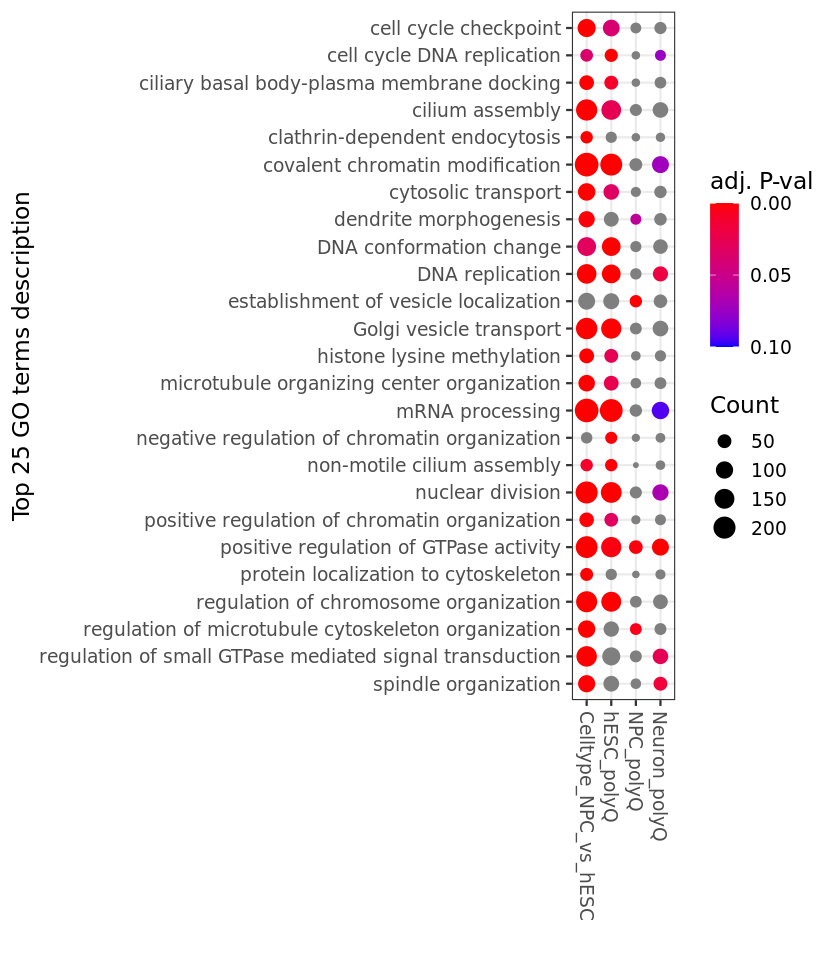

In [33]:
options(repr.plot.height=8,repr.plot.width=7)
ggo <- significantintronjunctionsintersectlistlongrenameddf.summarised.allenrichGOBP.df %>% 
subset(
    ID %in% (
        significantintronjunctionsintersectlistlongrenameddf.summarised.enrichGOBP.df %>% 
        subset((Description %in% includeterms) & !(Description %in% excludeterms)) %>% 
        arrange(p.adjust) %>% 
        with(ID) %>% unique %>% head(n=25)
    )
) %>% 
ggplot(
    mapping=aes(
        x=gsub('Cell_type','Celltype',gsub('disease_stage_','polyQ_',Dataset)) %>% 
        factor(
            levels=c('Celltype_NPCvsESC','polyQ_ESC','polyQ_NPC','polyQ_Neuron'),
            labels=c('Celltype_NPC_vs_hESC','hESC_polyQ','NPC_polyQ','Neuron_polyQ')
        ),
        y=Description %>% factor(levels=Description %>% factor %>% levels %>% rev),
        color=p.adjust,
        size=Count
    )
) +
geom_point() +
scale_color_gradient(name='adj. P-val',low='red',high='blue',limits=c(0,.1),breaks=c(0,.05,.1)) +
theme_bw(base_size=14) +
guides(color=guide_colorbar(reverse=TRUE)) +
labs(
    #title='Enriched GO terms',
    x='',
    y='Top 25 GO terms description'
) +
theme(
    axis.text.x=element_text(angle=270,hjust=0,vjust=.5),
    axis.text.y=element_text(),
    plot.title=element_text(hjust=0)
)

ggo


In [34]:
sessionInfo()


R version 4.0.2 (2020-06-22)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /opt/miniconda3/lib/libopenblasp-r0.3.10.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] plotly_4.10.0               car_3.0-10                 
 [3] carData_3.0-4               DESeq2_1.30.0              
 [5] SummarizedExperiment_1.20.0 Biobase_2.48.0             
 [7] MatrixGenerics_1.2.0        matrixStats_0.57.0         
 [9] GenomicRanges_1.42.0        GenomeInfoDb_1.